In [53]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import pygame

# Frozen Lake

#### Testing the environment

In [54]:
env = gym.make('FrozenLake-v1')

action_space_dim = env.action_space.n
state_space_dim = env.observation_space.n
print('Action space dim:      ',action_space_dim)
print('Observation space dim: ',state_space_dim)

Action space dim:       4
Observation space dim:  16


##### Actions:
- 0: Left
- 1: Down
- 2: Right
- 3: Up
##### Observations (states):
It represents the agent's current position in the map
##### Rewards:
- Reach goal +1
- Reach Hole 0
- Reach Frozen 0


#### Random policy and demo

In [55]:
# Vizualising the game
# Random policy

testenv = gym.make("FrozenLake-v1", render_mode = "human").env


for _ in range(10):
   state, info = testenv.reset() # resetting environment each episode 

   done, trunc = False, False # init

   while not(done or trunc):
      action = testenv.action_space.sample()  # randomly choosing an action
      state, reward, done, trunc, info = testenv.step(action)

testenv.close()
pygame.display.quit()
pygame.quit()

We're going to implement Q-learning and SARSA algorithms and compare the results.$\\$
Note: We will use $\epsilon$-greedy algorithms in both methods

We will choose $\alpha = 0.01$ and $\gamma = 1$ to simplify things at first. We might change this after. $\\$
We will also choose $\varepsilon = 1$ and have a decay rate of $0.0001$ to allow exploration in the first episodes. So now $\varepsilon$ will decay to $\varepsilon_{min}$ using this formula: $$\varepsilon = 0.1 + (1-0.1)e^{\tau \times i}$$
where $\tau$ is the decay rate and $i$ is the episode.

#### FrozenLakeAgent

In [97]:
class FrozenLakeAgent:
    def __init__(self, slip, alpha, gamma, epsilon, em=0.1):
        self.slip = slip                # is_slippery
        self.alpha = alpha              # learning rate
        self.gamma = gamma              # discount factor
        self.epsilon = epsilon          # for epsilon greedy policy
        self.em = em                    # minimal value of epsilon after decay
        self.Q = np.zeros((16,4))       # Q matrix
        self.policy = np.zeros(16)      # policy
        self.win = 0                   # win probability after testing performance
        self.env = gym.make('FrozenLake-v1', is_slippery=slip)


    def reset_policy(self):
        # resetting policy and Q matrix

        self.Q = np.zeros((16,4))
        self.policy = np.zeros(16)
        self.win = 0
    
    def Q_learning_train(self, decay_rate=0.0001, nb_episode=100000, nb_steps=1000):
        # nb_episode:   number of episodes 
        # nb_steps:     number of steps for each episode
        # decay_rate:   decay rate when updating epsilon

        history = [] # to save moves
        score = [] # to save rewards

        print('*********** Q learning training ***********')
    
        for episode in range(nb_episode):
            i = 0             # counting each episode's moves
            sk = 0            # counting each episode's rewards
            state, info = self.env.reset()
            for step in range(nb_steps):
                # taking action
                U = np.random.uniform(0,1)
                if U < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    action = np.argmax(self.Q[state])
                
                # taking step
                new_state, reward, done, trunc, info = self.env.step(action)
                
                
                #updating Q-matrix
                self.Q[state, action] = (1-self.alpha)*self.Q[state, action] + self.alpha*(reward + self.gamma*np.max(self.Q[new_state,:]))

                state = new_state
                i += 1
                sk += reward

                if done or trunc :
                    break

            # Saving moves and rewards    
            history.append(i)
            score.append(sk)            # if sk == 1 the agent won the game
            
            # Decay epsilon
            self.epsilon = self.em + (1 - self.em)*np.exp(decay_rate*episode)  # exponential decay
            
            # Visualizing progress
            if episode == 0:
                print('episode: ', episode + 1, ' wins: ', np.sum(score))
            if (episode + 1) % 10000 ==0:
                print('episode: ', episode + 1, ' wins: ', np.sum(score))
        
        # Saving policy
        self.policy = np.argmax(self.Q, axis=1)
        
        return self.policy, score, history
    




    def SARSA_train(self, decay_rate=0.0001, nb_episode=100000, nb_steps=1000):
        # nb_episode:   number of episodes 
        # nb_steps:     number of steps for each episode
        # decay_rate:   decay rate when updating epsilon

        history = [] # to save moves
        score = [] # to save rewards

        print('***********    SARSA training   ***********')

        for episode in range(nb_episode):
            i = 0             # counting each episode's moves
            sk = 0            # counting each episode's rewards
            
            # reset environment
            state, info = self.env.reset()
            
            # taking the first action
            action = np.argmax(self.Q[state])
            for step in range(nb_steps):
                # taking step
                new_state, reward, done, trunc, info = self.env.step(action)

                # taking new action from a new state
                # epsilon greedy
                U = np.random.uniform(0,1)
                if U < self.epsilon:
                    new_action = self.env.action_space.sample()
                else:
                    new_action = np.argmax(self.Q[new_state])
                
                #updating Q-matrix
                self.Q[state, action] = (1-self.alpha)*self.Q[state, action] + self.alpha*(reward + self.gamma*self.Q[new_state, new_action])

                state = new_state
                action = new_action
                
                i += 1
                sk += reward

                if done or trunc :
                    break

            # Saving moves and rewards    
            history.append(i)
            score.append(sk)            # if sk == 1 the agent won the game
            
            # Decay epsilon
            self.epsilon = self.em + (1 - self.em)*np.exp(decay_rate*episode)  # exponential decay
            
            # Visualizing progress
            if episode == 0:
                print('episode: ', episode + 1, ' wins: ', np.sum(score))
            elif (episode + 1) % 10000 ==0:
                print('episode: ', episode + 1, ' wins: ', np.sum(score))

        # Saving Policy
        self.policy = np.argmax(self.Q, axis=1)

        return self.policy, score, history
    


    
    def performance(self,policy, ep, viz=False):
        # policy:   policy to evaluate
        # ep:       number of episodes
        # viz:      visualize environment (or not)

        if viz:
            testenv = gym.make('FrozenLake-v1', render_mode='human', is_slippery=self.slip)
        else:
            testenv = gym.make('FrozenLake-v1', is_slippery=self.slip)
        
        
        wins = 0    # number of wins
    
        for t in range(ep):
            state, info = testenv.reset()
            
            done = False
            trunc = False

            while not (done or trunc):
                action = policy[state]  # choosing an action via the obtained policy 
                state, reward, done, trunc, info = testenv.step(action)
                wins += reward

        # closing environment
        testenv.close()
        pygame.display.quit()
        pygame.quit()

        self.win = wins

        # Printing results
        print('Number of wins:  ', int(wins), ' in ', ep, ' episodes.')
        print('Win probability: ', wins/ep)
        

        return self.win

We will compare how the agent acts when `is_slippery=True` (Agent1), and `is_slippery=False` (Agent2) 

In [98]:
Agent1 = FrozenLakeAgent(True, 0.01, 0.9, 1, 0.1)   # slippery agent
Agent2 = FrozenLakeAgent(False, 0.01, 0.9, 1, 0.1)  # non slippery agent

In [99]:
# Slippery Agent
pol1T, scr1T, hist1T = Agent1.Q_learning_train()
Agent1.reset_policy()            # resetting to reinitialize the Q matrix
pol2T, scr2T, hist2T = Agent1.SARSA_train()

*********** Q learning training ***********
episode:  1  wins:  0.0
episode:  10000  wins:  147.0
episode:  20000  wins:  280.0
episode:  30000  wins:  413.0
episode:  40000  wins:  562.0
episode:  50000  wins:  712.0
episode:  60000  wins:  865.0
episode:  70000  wins:  1015.0
episode:  80000  wins:  1177.0
episode:  90000  wins:  1312.0
episode:  100000  wins:  1427.0
***********    SARSA training   ***********
episode:  1  wins:  0.0
episode:  10000  wins:  113.0
episode:  20000  wins:  241.0
episode:  30000  wins:  381.0
episode:  40000  wins:  528.0
episode:  50000  wins:  678.0
episode:  60000  wins:  813.0
episode:  70000  wins:  939.0
episode:  80000  wins:  1076.0
episode:  90000  wins:  1218.0
episode:  100000  wins:  1364.0


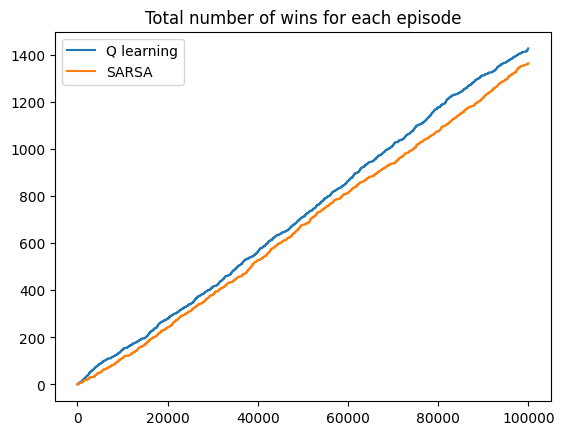

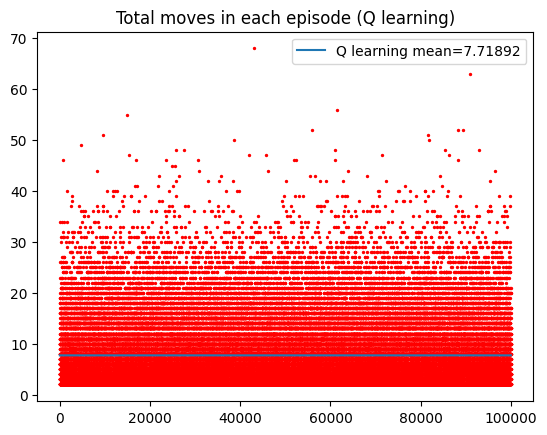

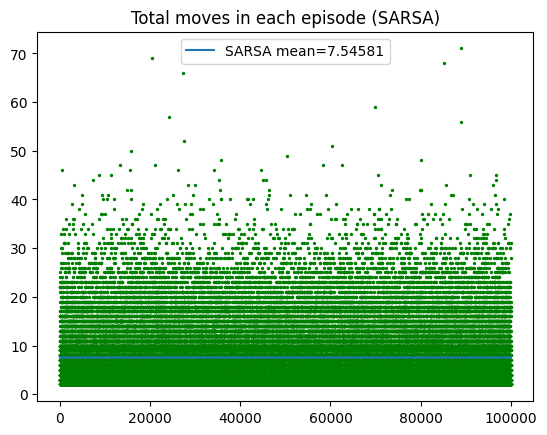

In [101]:
# Evaluating training performance
plt.plot(np.cumsum(scr1T), label='Q learning')
plt.plot(np.cumsum(scr2T), label='SARSA')
plt.title('Total number of wins for each episode')
plt.legend()
plt.show()



x_axis = range(len(hist1T))
mean1 = np.mean(hist1T)
mean2 = np.mean(hist2T)

# Evaluating training moves
plt.scatter(range(len(hist1T)), hist1T, s=2, c='r')
plt.plot(x_axis, [mean1 for i in x_axis], label='Q learning mean='+str(mean1))
plt.legend()
plt.title('Total moves in each episode (Q learning)')
plt.show()

plt.scatter(range(len(hist2T)), hist2T, s=2, c='g')
plt.plot(x_axis, [mean2 for i in x_axis], label='SARSA mean='+str(mean2))
plt.legend()
plt.title('Total moves in each episode (SARSA)')
plt.show()

In [103]:
# Evaluating performance
print('Q learning performance')
wins1 = Agent1.performance(pol1T,10000)
print('SARSA performance')
wins2 = Agent1.performance(pol2T,10000)

Q learning performance
Number of wins:   7264  in  10000  episodes.
Win probability:  0.7264
SARSA performance
Number of wins:   1596  in  10000  episodes.
Win probability:  0.1596


In [104]:
# Non slippery Agent
pol1F, scr1F, hist1F = Agent2.Q_learning_train()
Agent2.reset_policy()            # resetting to reinitialize the Q matrix
pol2F, scr2F, hist2F = Agent2.SARSA_train()

*********** Q learning training ***********
episode:  1  wins:  0.0
episode:  10000  wins:  140.0
episode:  20000  wins:  275.0
episode:  30000  wins:  429.0
episode:  40000  wins:  567.0
episode:  50000  wins:  704.0
episode:  60000  wins:  865.0
episode:  70000  wins:  1006.0
episode:  80000  wins:  1110.0
episode:  90000  wins:  1250.0
episode:  100000  wins:  1392.0
***********    SARSA training   ***********
episode:  1  wins:  0.0
episode:  10000  wins:  123.0
episode:  20000  wins:  230.0
episode:  30000  wins:  381.0
episode:  40000  wins:  530.0
episode:  50000  wins:  692.0
episode:  60000  wins:  858.0
episode:  70000  wins:  1023.0
episode:  80000  wins:  1168.0
episode:  90000  wins:  1330.0
episode:  100000  wins:  1490.0


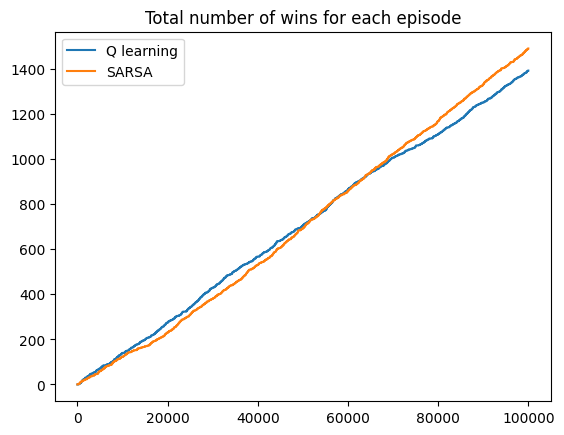

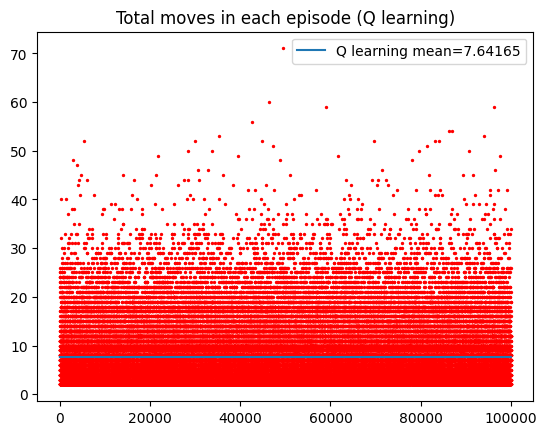

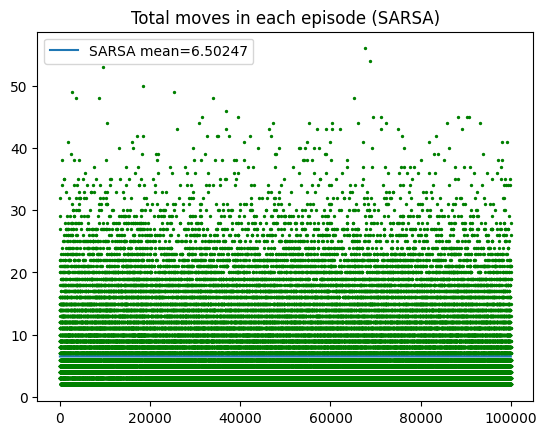

In [105]:
# Evaluating training performance
plt.plot(np.cumsum(scr1F), label='Q learning')
plt.plot(np.cumsum(scr2F), label='SARSA')
plt.title('Total number of wins for each episode')
plt.legend()
plt.show()


x_axis = range(len(hist1F))
mean1 = np.mean(hist1F)
mean2 = np.mean(hist2F)

# Evaluating training moves
plt.scatter(range(len(hist1F)), hist1F, s=2, c='r')
plt.plot(x_axis, [mean1 for i in x_axis], label='Q learning mean='+str(mean1))
plt.legend()
plt.title('Total moves in each episode (Q learning)')
plt.show()

plt.scatter(range(len(hist2F)), hist2F, s=2, c='g')
plt.plot(x_axis, [mean2 for i in x_axis], label='SARSA mean='+str(mean2))
plt.legend()
plt.title('Total moves in each episode (SARSA)')
plt.show()

In [106]:
# Evaluating performance
print('Q learning performance')
wins1 = Agent2.performance(pol1F,10000)
print('SARSA performance')
wins2 = Agent2.performance(pol2F,10000)

Q learning performance
Number of wins:   10000  in  10000  episodes.
Win probability:  1.0
SARSA performance
Number of wins:   10000  in  10000  episodes.
Win probability:  1.0


It's clear that it's much more difficult to solve the environment when `is_slippery = True`. $\\$
When the ice is slippery, the agent won't move in the intended direction. This adds randomness to the chosen action. $\\$ When `is_slippery = False`, things are easier. The results above show that the agent had a 100% win rate with both Q-learning and SARSA algorithms.

Q-learning is known to have better performance than SARSA in environments with high stochasticity.
When `is_slippery=True`, the environment is more stochastic, which explains the better performance (win rate) when implementing Q-learning. However, when `is_slippery=False`, the environment is deterministic, and both alogrithms had 100% win rate just like we mentionned before.

# Acrobot

In [107]:
env = gym.make('Acrobot-v1', render_mode='human')
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]

print('Action space dim:      ',action_dim)
print('Observation space dim: ',state_dim)

Action space dim:       3
Observation space dim:  6


##### Actions:
- 0: apply -1 torque to the actuated joint 
- 1: apply 0 torque to the actuated joint
- 2: apply 1 torque to the actuated joint
##### Observations (states):
- Cosine of `theta1`
- Sine of `theta1`
- Cosine of `theta2`
- Sine of `theta2`
- Angular velocity of `theta1`
- Angular velocity of `theta2`
##### Rewards:
The goal is to have the free end reach a designated target height in as few steps as possible, and as such all steps that do not reach the goal incur a reward of -1. Achieving the target height results in termination with a reward of 0. The reward threshold is -100.

### Random Policy and Demo

In [108]:
n_episodes = 5
n_steps = 50

# Random Policy
rewards = []
for i in range(n_episodes):
    score = 0
    state, info = env.reset()
    for j in range(n_steps):
        action = np.random.choice(action_dim)
        state, reward, done, trunc, info = env.step(action)
        score += reward
        if done or trunc:
            break
    print(f'Episode {i+1} rewards: ',score)
    rewards.append(score)

pygame.display.quit()
pygame.quit()

Episode 1 rewards:  -50.0
Episode 2 rewards:  -50.0
Episode 3 rewards:  -50.0
Episode 4 rewards:  -50.0
Episode 5 rewards:  -50.0


We will apply the REINFORCE algorithm to solve the Acrobot environment. We will choose a softmax policy.
$$S_i = softmax(u)_{i} = \frac{e^{u_{i}}}{\sum_{j}^{3}e^{u_{j}}}$$
where $u = x^{T}\theta$ $\\$
In this case, our policy is $$\pi(a|x) = softmax(x^{T}\theta)$$
We will have to compute the gradient of the $\log$ of the policy $\nabla\log\pi(a|x)$
$$\nabla\log\pi(a|x) = \frac{\nabla\pi(a|x)}{\pi(a|x)}$$

The derivative of the softmax function for arbitrary $i$,$j$:
$$\frac{\partial S_i}{\partial u_j} = \left\{\begin{matrix}
 S_i(1-S_j) & \text{if} \quad i = j \\ 
 -S_i S_j &  \text{if} \quad i \neq j
\end{matrix}\right.$$ 

In [110]:
def softmax(x):
    x = x - np.max(x)   # for numerical stability (avoid OverflowError)
    p = np.exp(x)
    return p/np.sum(p)


def softmax_jacobian(x):
    n = x.shape[1]
    J = np.zeros((n,n))
    
    s = softmax(x)

    for i in range(n):
        for j in range(n):
            if i != j:
                J[i,j] = -s[:, i]*s[:, j]
            else:
                J[i,j] = s[:, i]*(1 - s[:, j])
    return J

In [205]:
class AcrobotAgent:
    def __init__(self):
        self.theta = np.random.uniform(-0.25, 0.25, size=(6, 3))
        self.env = gym.make('Acrobot-v1')

    def policy(self, state, theta):
        x = np.dot(state, theta)
        proba = softmax(x)
        action = np.random.choice([0, 1, 2], p=proba[0])
        return action, proba

    def reset_policy(self):
        self.theta = np.random.uniform(0, 1, size=(6, 3))
        

    def reinforce_train(self, learning_rate=0.0001, gamma=0.99, nb_episode=20000):

        print('***********    REINFORCE training   ***********')

        for episode in range(nb_episode):
            rewards_history = []
            score = 0
            Gradient = []
            done, trunc = False, False
            state, info = self.env.reset()
            state = state[None, :]      # reshape state from (6,) to (1,6)

            # generating a whole episode
            while not (done or trunc):
                # generating episode steps
                action, proba = self.policy(state, self.theta)   # taking action and returning probabilities
                next_state, reward, done, trunc, info = self.env.step(action)   # taking step   
                
                # computing the gradient gradually
                J = softmax_jacobian(np.dot(state, self.theta))  # softmax jacobian
                J_a = J[action, :]      # taking current action
                loggrad = J_a/proba[:, action]
                loggrad = loggrad[None, :]      # reshape from (3,) to (1,3)
                grad = np.dot(np.transpose(state), loggrad)
                Gradient.append(grad)
                
                state = next_state[None, :]     # reshape from (6,) to (6,1)
                rewards_history.append(reward)      # saving reward to calculate discounted return
                score += reward                    # score = total episode rewards

            rewards.append(score)                  # saving episode score

            
            # Calculating the discounted return
            for i in range(len(Gradient)):
                discounted_return = 0
                for j in range(len(rewards_history[i:])):
                    discounted_return += rewards_history[i+j] * (gamma ** j)
                update = learning_rate * Gradient[i] * discounted_return
                self.theta += update

            # Visualizing progress
            if episode == 0:
                print('episode: ', episode + 1, ' reward: ', np.sum(score))
            elif (episode + 1) % 1000 ==0:
                print('episode: ', episode + 1, ' reward: ', np.sum(score))

        return self.theta, rewards
    
    

    def performance(self, theta, n_ep=1000, viz=False):

        if viz:
            testenv = gym.make('Acrobot-v1', render_mode='human')
        else:
            testenv = gym.make('Acrobot-v1')


        rewards = []    # saves the rewards of each episode
        steps = []      # saves the number of steps of each episode


        for epsiode in range(n_ep):

            state, info = testenv.reset()
            k = 0           #steps counter
            score = 0       #episode's rewards
            done, trunc = False, False

            while not(done or trunc):

                state = state[None, :]      # reshape from (6,) to (1,6)
                action, proba = self.policy(state, theta)
                state, reward, done, trunc, info = testenv.step(action)
                score += reward
                k += 1

            rewards.append(score)
            steps.append(k + 1)


        # Closing test environment
        testenv.close()
        pygame.display.quit()
        pygame.quit()    


        # Printing results
        mean_steps = np.mean(steps)
        print(f'Average number of steps = {mean_steps}')


        return rewards, steps

In [206]:
Agent = AcrobotAgent()

In [207]:
theta, history = Agent.reinforce_train()

***********    REINFORCE training   ***********
episode:  1  reward:  -500.0
episode:  1000  reward:  -172.0
episode:  2000  reward:  -84.0
episode:  3000  reward:  -137.0
episode:  4000  reward:  -78.0
episode:  5000  reward:  -132.0
episode:  6000  reward:  -74.0
episode:  7000  reward:  -106.0
episode:  8000  reward:  -82.0
episode:  9000  reward:  -73.0
episode:  10000  reward:  -77.0
episode:  11000  reward:  -96.0
episode:  12000  reward:  -65.0
episode:  13000  reward:  -94.0
episode:  14000  reward:  -122.0
episode:  15000  reward:  -63.0
episode:  16000  reward:  -71.0
episode:  17000  reward:  -145.0
episode:  18000  reward:  -66.0
episode:  19000  reward:  -67.0
episode:  20000  reward:  -83.0


*******         theta          ********
[[ 1.02508318 -1.22156829 -0.00704196]
 [-0.39643461 -0.56517289  0.80329748]
 [ 0.89091399 -1.24630243  0.32187507]
 [ 0.21515749  0.84240763 -0.98442193]
 [ 0.38276374  1.56723908 -1.48935503]
 [-3.31833771  0.69029668  2.53020109]]


Text(0.5, 1.0, 'Evolution of the average training rewards')

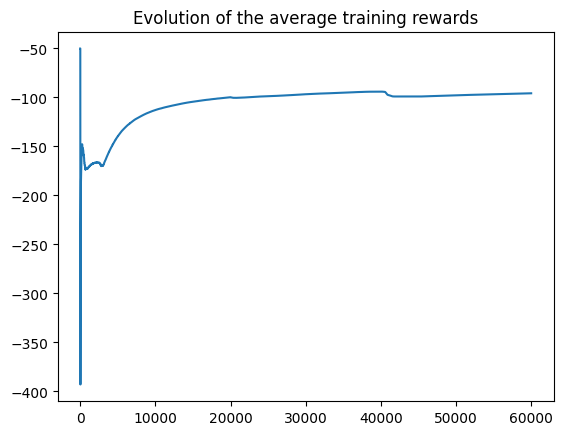

In [208]:
print('*******         theta          ********')
print(theta)

#Training performance
plt.plot(np.arange(1, len(history) + 1), np.cumsum(history)/np.arange(1, len(history) + 1))
plt.title('Evolution of the average training rewards')

In [209]:
# Evaluating the optimal performance
rewards_hist, steps_hist = Agent.performance(theta=theta)

Average number of steps = 87.342


Text(0.5, 1.0, 'Evolution of the average number of steps')

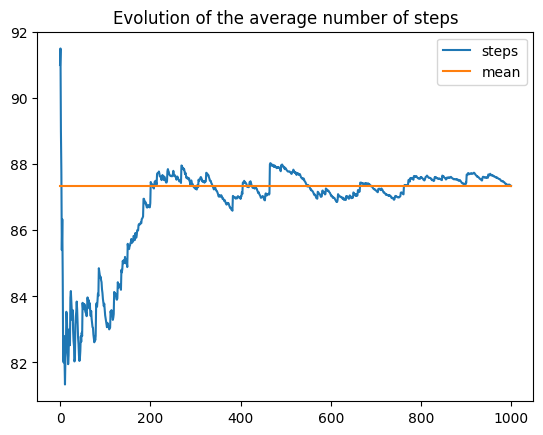

In [210]:
plt.plot(np.cumsum(steps_hist)/np.arange(1, len(steps_hist)+1), label='steps')
plt.plot([np.mean(steps_hist) for i in range(len(steps_hist))], label='mean')
plt.legend()
plt.title('Evolution of the average number of steps')

The algorithm takes a lot of time to run. And we also notice that after training, it takes a couple hundred episodes to converge. $\\$
After training the agent multiple times we notice that the average number of steps is in the high 80s and it seems like a satisfying result. $\\$
As mentionned in the code, to initialize $\theta$ we generated $6\times3$ values of the uniform distribution. We noticed that changing the initialization has an impact on the convergence speed of the algorithm. 

To improve the result we can tune our parameters by testing different values of the discount factor $\gamma$ and the learning rate. $\\$
Another thing that might be useful is having a decaying learning rate just like we did with the Frozen Lake environment to allow more exploration in the beginning of training.